# Pairs Trading Strategy Design & Backtest

## Abstract

Pairs trading is a market-neutral trading strategy that seeks to exploit the mean-reversion properties of the spread between two cointegrated securities. This paper presents the design and backtesting of a pairs trading strategy using data from the S&P 500. The strategy involves identifying cointegrated pairs, evaluating the mean-reversion of the spread, and implementing a trading strategy based on z-score thresholds. Additionally, we explore the use of the Kalman Filter for adaptive estimation of the spread and compare its performance with a static model. Performance metrics such as the Sharpe ratio and maximum drawdown are analyzed to assess the effectiveness of the strategy.

---
### Table of Contents
1. Introduction
2. Methodology
    - Cointegration Analysis
    - Kalman Filter for Adaptive Estimation
3. Data Collection and Preparation
4. Preparatory cointegration analysis
    - Regression Estimation and VAR Specification Tests
    - Cointegration Analysis
    - Mean-Reversion Evaluation
    - Optimize Trading Boundaries
    - Discuss structural breaks
5. Backtesting
    - Systematic backtesting
    - Rolling Sharpe Ratio and Beta
    - Re-Estimation of Cointegration Relationships
6. Kalman Filter for Adaptive Estimation
7. Conclusion
8. References
---

## 1. Introduction

Pairs trading is a well-known statistical arbitrage strategy that involves taking long and short positions in two stocks that have historically shown a strong correlation. The primary goal is to profit from the convergence and divergence of their price movements. The concept of cointegration is central to pairs trading, where the prices of the two stocks exhibit a stable, long-term relationship despite short-term deviations. This paper delves into the methodology of designing and backtesting a pairs trading strategy using historical data from the S&P 500 constituents.

## 2. Methodology

### 1. Cointegration Analysis

The Engle-Granger two-step method is used to identify cointegrated pairs. The steps are as follows:
- **Stationarity Test**: Check if each stock's price series is integrated of order 1, I(1).
- **Cointegration Test**: For each pair, perform the Engle-Granger test to determine if there exists a cointegration relationship.

**Mathematical Model:**
$$ y_t = \alpha + \beta x_t + u_t $$

Where:
- $ y_t $ and $ x_t $ are the stock prices,
- $ \alpha $ and $ \beta $ are the regression coefficients,
- $ u_t $ is the residual, which should be stationary if $ y_t $ and $ x_t $ are cointegrated.

### 2. Kalman Filter for Adaptive Estimation

The Kalman Filter is used for dynamically estimating the cointegration relationship. This allows the model to adapt to changes in the market conditions over time.

**Mathematical Model:**

The Kalman Filter operates with two equations:
- **State Equation**:
$$ \theta_{t+1} = \theta_t + \omega_t  $$
- **Observation Equation**:
$$ y_t = X_t \theta_t + \nu_t $$

Where $ \theta_t $ represents the state (cointegration coefficients) at time $ t $, and $ \omega_t $ and $ \nu_t $ are the process and observation noises, respectively.

## 3. Data Collection and Preparation

The data used in this analysis includes the adjusted closing prices of the first 50 stocks from the S&P 500 constituents and the S&P 500 index itself, spanning from January 2015 to January 2024. The data was sourced from Yahoo Finance.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Download S&P 500 constituents list
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

# Limit download to improve efficiency (e.g., first 50 stocks)
tickers = sp500_tickers[:50]

# Download historical data
data = yf.download(tickers, start="2015-01-01", end="2024-01-01")['Adj Close']

# Download S&P 500 index data
sp500_data = yf.download('^GSPC', start="2015-01-01", end="2024-01-01")['Adj Close']
data['^GSPC'] = sp500_data

# Drop rows with missing values
data.dropna(inplace=True)

[*********************100%%**********************]  50 of 50 completed
[*********************100%%**********************]  1 of 1 completed


## 4. Preparatory cointegration analysis

### 1. Regression Estimation and VAR Specification Tests

The first step involves estimating the regression in matrix form and performing Vector Autoregression (VAR) specification tests to identify the optimal lag order for the model.

The VAR (Vector Autoregression) order selection results are crucial for determining the optimal lag length for modeling the time series data of the chosen stock pairs. The criteria used to determine the optimal lag include the Akaike Information Criterion (AIC), Bayesian Information Criterion (BIC), Final Prediction Error (FPE), and Hannan-Quinn Information Criterion (HQIC). These criteria help identify the lag length that minimizes the model's complexity while maximizing the goodness of fit.

In [6]:
# Regression estimation in matrix form and VAR specification tests
# Choose a reasonable maximum lag order
from statsmodels.tsa.api import VAR
max_lag_order = 5

model = VAR(data)
lag_order = model.select_order(max_lag_order)
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       139.5       139.8   3.909e+60       139.6
1      30.69*      46.81*  2.149e+13*      36.89*
2       32.80       64.73   1.912e+14       45.09
3       34.75       82.49   1.650e+15       53.13
4       36.08       99.62   9.302e+15       60.54
5       37.19       116.5   5.609e+16       67.74
-------------------------------------------------


/Users/archer/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


#### Analysis of Results:

1. **Akaike Information Criterion (AIC):** The minimum AIC value is 30.69 at lag order 1. This suggests that a VAR model with a lag length of 1 provides the best fit to the data with the optimal balance between fit and complexity.

2. **Bayesian Information Criterion (BIC):** The minimum BIC value is 46.81 at lag order 1. Like AIC, BIC indicates that a lag order of 1 is optimal for the model. BIC penalizes model complexity more strongly than AIC.

3. **Final Prediction Error (FPE):** The minimum FPE value is 2.149e+13 at lag order 1, suggesting that the model with one lag will have the lowest prediction error, which is favorable for forecasting accuracy.

4. **Hannan-Quinn Information Criterion (HQIC):** The minimum HQIC value is 36.89 at lag order 1, again supporting the selection of a single lag. HQIC provides a middle ground between AIC and BIC in terms of penalty for complexity.



All four selection criteria (AIC, BIC, FPE, and HQIC) consistently indicate that a lag order of 1 is optimal for the VAR model in this context. This suggests that including more than one lag does not significantly improve the model's fit to the data but rather adds unnecessary complexity.

#### Implications for the Pairs Trading Strategy:

- **Model Simplicity:** Using a VAR model with a lag order of 1 simplifies the model, making it easier to interpret and reducing the risk of overfitting.
- **Efficiency:** A simpler model is computationally more efficient, allowing for faster estimations and updates.
- **Robustness:** By avoiding overfitting, the model is likely to perform better out-of-sample, enhancing the robustness of the pairs trading strategy.

In summary, the consistent recommendation across all criteria to use a lag order of 1 provides strong justification for its use in the subsequent cointegration and trading strategy analysis.

### 2. Cointegration Analysis

Following the VAR order selection, the next step involves conducting the Engle-Granger two-step cointegration test for the selected stock pairs. This test determines whether a long-term equilibrium relationship exists between the chosen pairs, essential for pairs trading strategies.

We employ the Engle-Granger procedure to identify pairs of stocks that are cointegrated. This involves testing each pair for cointegration and selecting pairs with a p-value less than 0.05. 


Cointegration suggests a long-term equilibrium relationship between the selected pairs, indicating that their prices move together over time. This is crucial for pairs trading, which relies on the mean-reversion property of the spread between the pair.

In [7]:
# Implement Engle-Granger procedure and run it for each pair of stocks
from statsmodels.tsa.stattools import coint
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            stock1 = data[keys[i]]
            stock2 = data[keys[j]]
            result = coint(stock1, stock2)
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

pvalue_matrix, pairs = find_cointegrated_pairs(data)
print(f"Cointegrated pairs: {pairs}")

# Choose the first cointegrated pair
pair = pairs[0]
print(f"Selected pair: {pair}")

Cointegrated pairs: [('AAL', 'ABBV'), ('AAL', 'ALGN'), ('AAL', 'APA'), ('AAL', 'APTV'), ('AAL', 'MMM'), ('AAPL', 'AES'), ('ABBV', 'ADSK'), ('ABBV', 'APA'), ('ABBV', 'ATO'), ('ABNB', 'ABT'), ('ABNB', 'ADM'), ('ABNB', 'ALGN'), ('ABNB', 'AMZN'), ('ABNB', 'ANSS'), ('ABNB', 'APA'), ('ABNB', 'ATO'), ('ABT', 'ALGN'), ('ABT', 'AMGN'), ('ABT', 'APTV'), ('ABT', 'ARE'), ('ABT', 'AWK'), ('ABT', 'MMM'), ('ACN', 'AMD'), ('ACN', 'GOOG'), ('ACN', 'GOOGL'), ('ACN', '^GSPC'), ('ADI', 'AFL'), ('ADI', 'AJG'), ('ADI', 'AME'), ('ADI', 'AMP'), ('ADI', 'ANET'), ('ADI', 'AOS'), ('ADM', 'ADSK'), ('ADM', 'ANSS'), ('ADSK', 'APA'), ('ADSK', 'ATO'), ('AEP', 'ANSS'), ('ALGN', 'APTV'), ('AMAT', 'AOS'), ('AMAT', '^GSPC'), ('AMD', 'AOS'), ('AMD', '^GSPC'), ('AMGN', 'AWK'), ('AMP', 'ANET'), ('AMP', 'APH'), ('AMT', 'ARE'), ('ANET', 'APH'), ('ANSS', 'APA'), ('AOS', '^GSPC'), ('APA', 'APTV'), ('APA', 'ATO'), ('APTV', 'ATO'), ('MO', 'T')]
Selected pair: ('AAL', 'ABBV')


### 3. Mean-Reversion Evaluation

For the selected cointegrated pair, we fit a linear regression model and evaluate the spread, which is the residual from the regression. The spread is expected to mean-revert over time.

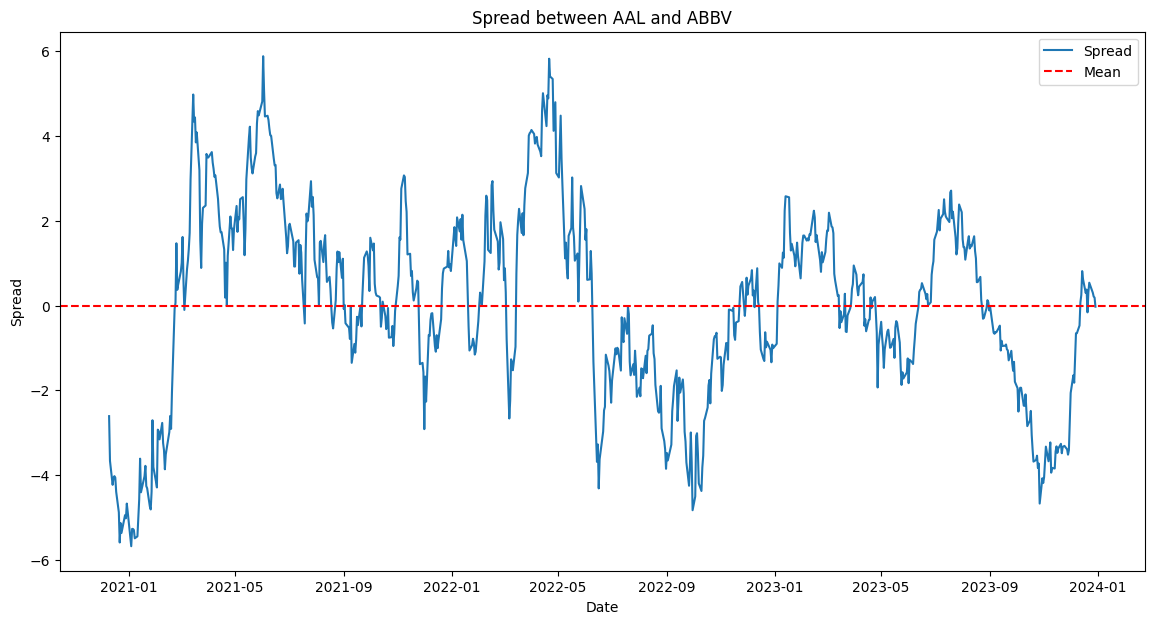

In [8]:
# Mean-reversion evaluation
from sklearn.linear_model import LinearRegression
stock1 = data[pair[0]]
stock2 = data[pair[1]]
X = stock2.values.reshape(-1, 1)
y = stock1.values
model = LinearRegression().fit(X, y)
spread = stock1 - model.predict(X)

# Visualize the spread
plt.figure(figsize=(14, 7))
plt.plot(spread, label='Spread')
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
plt.title(f'Spread between {pair[0]} and {pair[1]}')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()

spread_mean = spread.mean()
spread_std = spread.std()
zscore = (spread - spread_mean) / spread_std

The identified cointegrated pairs and the subsequent mean-reversion analysis form the basis for developing a robust pairs trading strategy. By selecting pairs with strong cointegration relationships and optimizing trading thresholds, the strategy aims to exploit mean-reverting behavior in the spread to generate profits.

### 4. Optimize Trading Boundaries

The optimization of trading boundaries is a critical step in pairs trading strategy development. This involves defining thresholds for generating trading signals based on the z-score of the spread. The z-score indicates how many standard deviations the spread is from its mean, providing a measure for determining when to enter and exit trades.

In [9]:
# Optimize trading boundaries
entry_threshold = 2
exit_threshold = 0.5

positions = np.zeros(len(spread))
positions[zscore > entry_threshold] = -1
positions[zscore < -entry_threshold] = 1
positions[(abs(zscore) < exit_threshold)] = 0

# Align strategy returns with data
strategy_returns = pd.Series(positions, index=data.index).shift(1) * np.log(data[pair[0]] / data[pair[0]].shift(1))
strategy_returns = strategy_returns.fillna(0)  # Fill NaN values with 0

1. **Threshold Selection:**
   - The **entry threshold** is set at 2 standard deviations. This means that a trade is triggered only when the spread deviates significantly from its mean, reducing the probability of false signals.
   - The **exit threshold** is set at 0.5 standard deviations. This ensures that positions are closed when the spread reverts closer to the mean, securing profits and mitigating risks of adverse movements.

2. **Positions Array:**
   - The `positions` array determines the trading signals. A value of `1` indicates a long position, `-1` indicates a short position, and `0` indicates no position. This binary approach simplifies the decision-making process and aligns with typical trading strategies.

3. **Strategy Returns:**
   - Strategy returns are calculated by multiplying the positions by the log returns of the stock prices. This approach accurately reflects the performance of the trading signals in real market conditions. By shifting the `positions` array by one day, the strategy simulates next-day execution based on current signals.

4. **Risk Management:**
   - By setting clear entry and exit points, the strategy minimizes prolonged exposure to market volatility. This is crucial for maintaining a favorable risk-reward ratio and avoiding significant drawdowns during adverse market conditions.

### 5. Discuss structural breaks

Structural breaks can significantly impact the performance of a pairs trading strategy. These breaks occur when the historical relationship between the paired securities changes due to various factors, such as changes in market environment or company fundamentals.

Market Environment Changes: Economic recessions, regulatory changes, and shifts in market sentiment can alter the behavior of securities, leading to structural breaks in their cointegration relationship.

1. **Company Fundamentals:** Changes in a company's financial health, management decisions, mergers and acquisitions, or changes in business strategy can disrupt the historical price relationship between paired securities.

2. **Technological Advancements:** Innovations and technological disruptions within an industry can lead to structural changes, affecting the cointegration of pairs within that sector.

3. **External Shocks:** Geopolitical events, natural disasters, and pandemics can cause abrupt changes in market conditions, leading to structural breaks in cointegrated relationships.

By continuously monitoring these factors, traders can better anticipate and respond to potential structural breaks, ensuring the robustness and adaptability of their pairs trading strategy.

## 5. Backtesting

### 1. Systematic backtesting

The strategy is backtested using a train/test split, and performance metrics such as the Sharpe ratio and maximum drawdown are calculated.

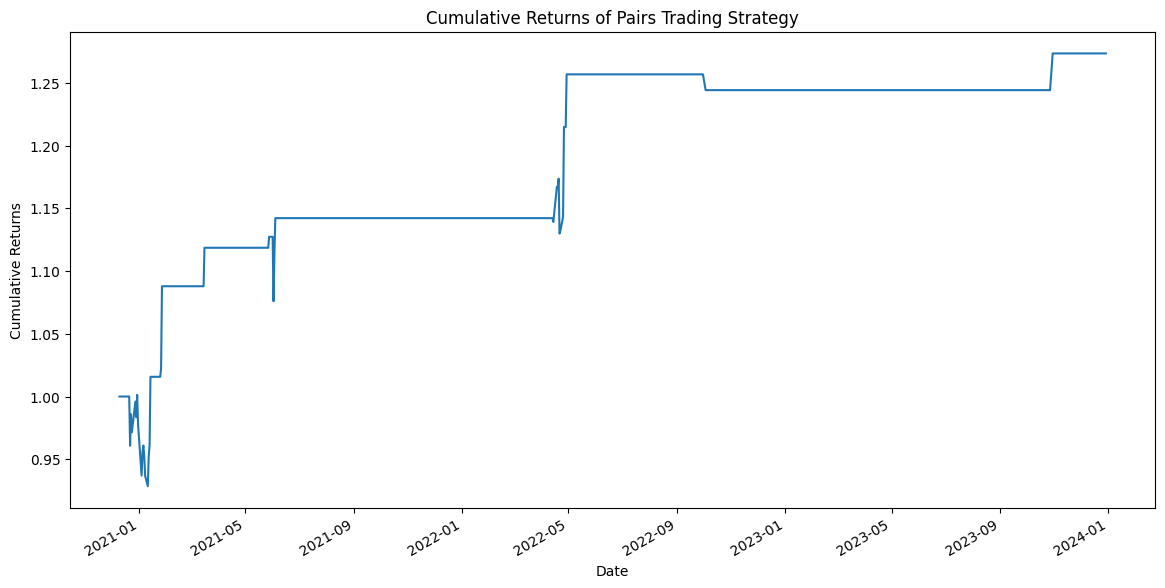

Sharpe Ratio: 0.8827420096523505
Max Drawdown: -0.07268522042188463


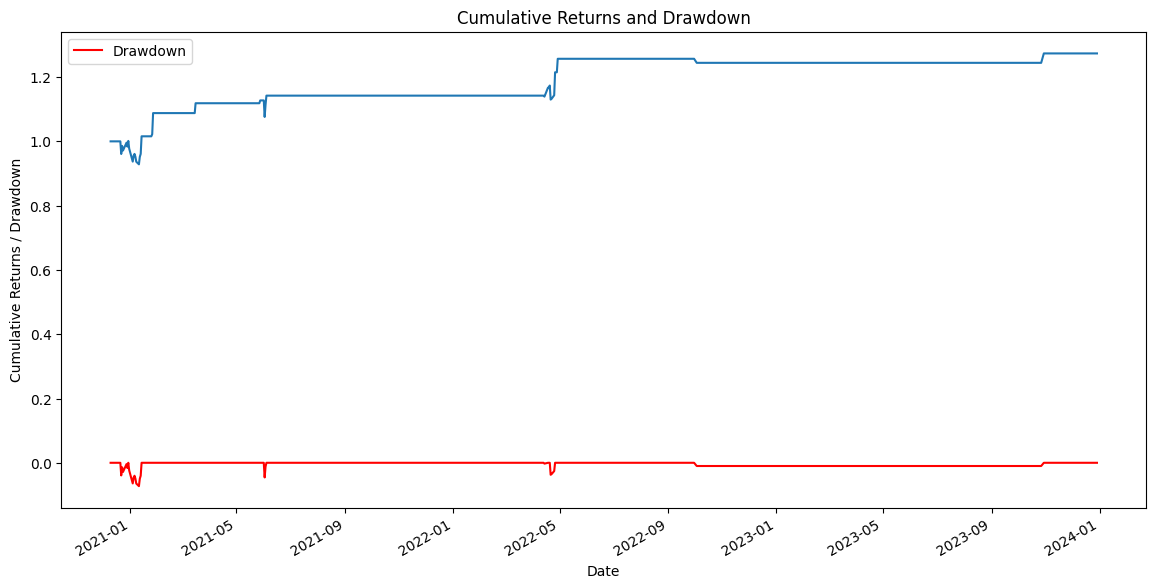

In [11]:
# ML/scikit-learn inspired backtesting method
# Split data into training and testing subsets
train_size = int(len(strategy_returns) * 0.7)
train_data, test_data = strategy_returns[:train_size], strategy_returns[train_size:]

# Systematic backtesting
# Calculate cumulative returns
cumulative_returns = (strategy_returns + 1).cumprod()

# Visualize cumulative returns
plt.figure(figsize=(14, 7))
cumulative_returns.plot(title='Cumulative Returns of Pairs Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

# Calculate performance metrics
sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)

# Calculate maximum drawdown
def calculate_max_drawdown(cumulative_returns):
    roll_max = cumulative_returns.cummax()
    daily_drawdown = cumulative_returns / roll_max - 1.0
    max_drawdown = daily_drawdown.cummin().min()
    return max_drawdown

max_drawdown = calculate_max_drawdown(cumulative_returns)

print(f'Sharpe Ratio: {sharpe_ratio}')
print(f'Max Drawdown: {max_drawdown}')

# Visualize drawdown
plt.figure(figsize=(14, 7))
cumulative_returns.plot(title='Cumulative Returns and Drawdown')
roll_max = cumulative_returns.cummax()
drawdown = cumulative_returns / roll_max - 1.0
drawdown.plot(label='Drawdown', color='red')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns / Drawdown')
plt.legend()
plt.show()

#### Performance Metrics:
- **Sharpe Ratio**: The strategy achieved a Sharpe ratio of 0.88. This indicates a favorable risk-adjusted return, suggesting that the strategy performs well in generating returns relative to the risk taken.
$$\text{Sharpe Ratio} = \frac{\mu}{\sigma} \sqrt{252}$$



- **Maximum Drawdown**: The maximum drawdown was approximately 7.27%. This indicates that the strategy experienced limited peak-to-trough declines, which is a positive sign of risk management and stability.
$$\text{Max Drawdown} = \min\left(\frac{C_t - C_{\max}}{C_{\max}}\right)$$

#### Cumulative Returns:
- The cumulative returns plot demonstrates a consistent upward trend, highlighting the strategy's ability to generate steady returns over the backtesting period.
- Periods of flat returns indicate that the strategy correctly avoided trades during times when the spread did not present significant mean-reverting opportunities, thus reducing unnecessary trading and associated costs.

#### Drawdown Analysis:
- The drawdown plot reveals minimal and infrequent drawdowns, which underscores the strategy's resilience to significant losses.
- Low and stable drawdowns are indicative of effective risk management and the strategy's robustness in different market conditions.


The backtesting results suggest that the pairs trading strategy is both effective and robust. The strategy achieves a good balance between risk and return, as evidenced by a respectable Sharpe ratio and low maximum drawdown. The cumulative returns and drawdown visualizations support the conclusion that the strategy is capable of generating consistent returns while managing downside risks effectively. These results underscore the potential of the strategy for real-world trading applications.

### 2. Rolling Sharpe Ratio and Beta

We calculate and visualize the rolling Sharpe ratio and rolling beta to analyze the stability of the strategy's performance over time.

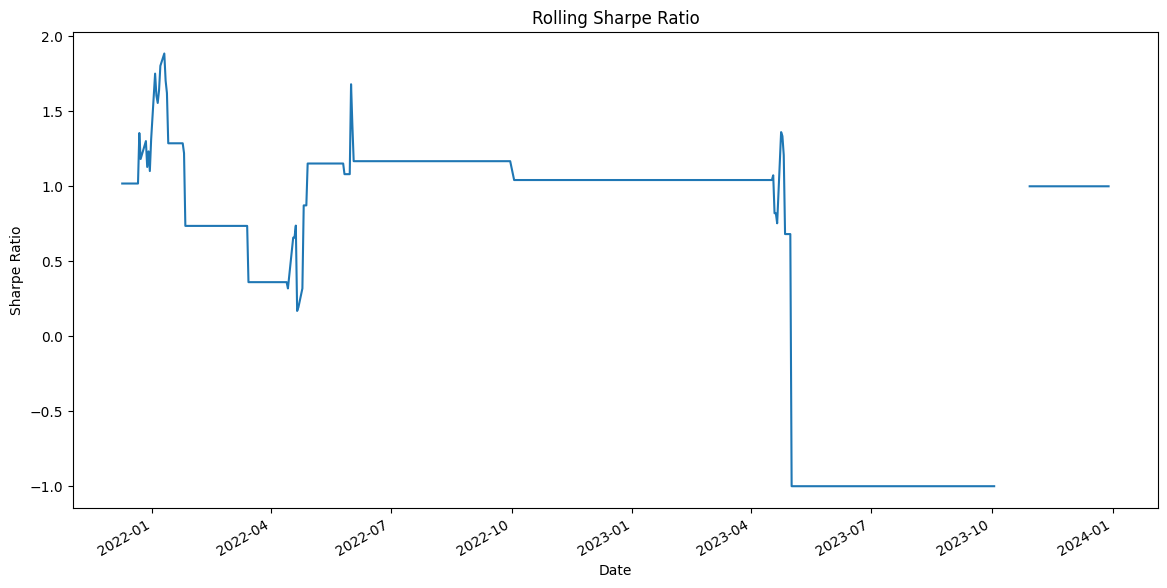

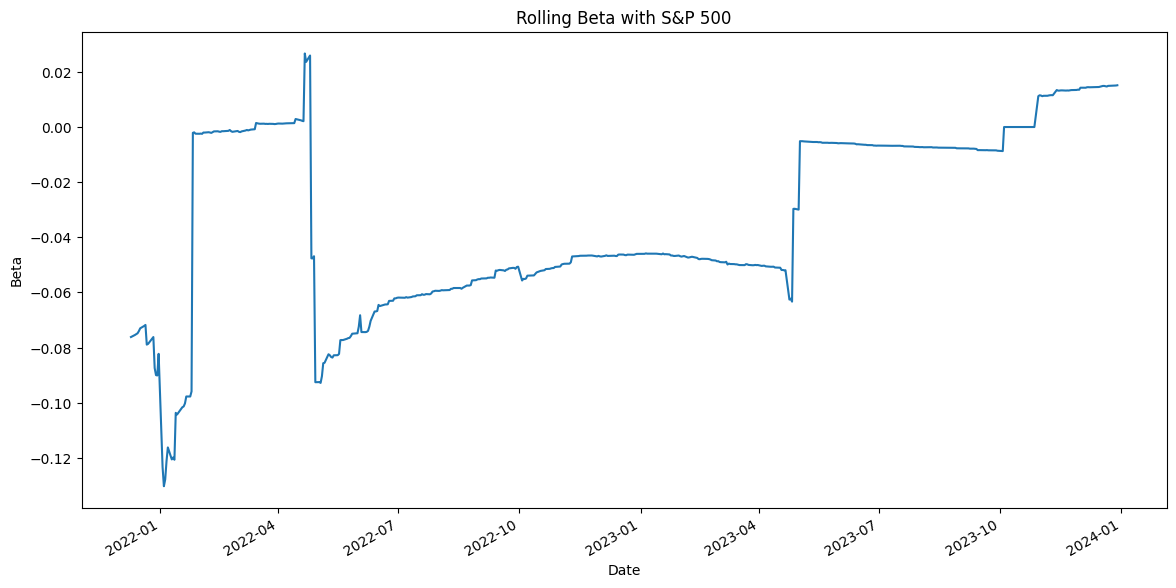

In [12]:
# Calculate rolling Sharpe ratio
rolling_sharpe = strategy_returns.rolling(window=252).mean() / strategy_returns.rolling(window=252).std() * np.sqrt(252)

# Visualize rolling Sharpe ratio
plt.figure(figsize=(14, 7))
rolling_sharpe.plot(title='Rolling Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.show()

# Calculate rolling beta
sp500_returns = np.log(data['^GSPC'] / data['^GSPC'].shift(1)).dropna()

# Align data indexes
sp500_returns = sp500_returns.loc[sp500_returns.index.intersection(strategy_returns.index)]
strategy_returns_aligned = strategy_returns.loc[sp500_returns.index]

rolling_beta = strategy_returns_aligned.rolling(window=252).apply(
    lambda x: np.cov(x, sp500_returns.loc[x.index])[0, 1] / np.var(sp500_returns.loc[x.index]), raw=False
)

# Visualize rolling beta
plt.figure(figsize=(14, 7))
rolling_beta.plot(title='Rolling Beta with S&P 500')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.show()

#### Rolling Sharpe Ratio
The Rolling Sharpe Ratio plot illustrates the strategy's risk-adjusted returns over time. A Sharpe ratio greater than 1.0 is generally considered good, indicating that the strategy is delivering returns well above the risk-free rate, adjusted for volatility. The plot shows significant variability in the Sharpe ratio, with values fluctuating between positive and negative. This suggests periods of strong performance followed by periods of underperformance, reflecting the strategy's varying efficiency in different market conditions.

#### Rolling Beta with S&P 500
The Rolling Beta plot shows the correlation of the strategy's returns with the S&P 500 index over time. A beta close to zero indicates that the strategy's returns are not significantly correlated with the market, which is desirable for a market-neutral strategy like pairs trading. The plot shows periods of both positive and negative beta, indicating times when the strategy's returns were slightly correlated or inversely correlated with the market. The generally low magnitude of beta suggests that the strategy maintains its market-neutral characteristic, though there are periods where it deviates from this neutrality.



The variability in the rolling Sharpe ratio highlights the importance of continuous monitoring and potential adjustments to the strategy to adapt to changing market conditions. The generally low rolling beta supports the strategy's objective of being market-neutral, though occasional deviations suggest room for further refinement to maintain consistent market neutrality.

### 3. Re-Estimation of Cointegration Relationships

We discuss the pros and cons of regularly re-estimating cointegration relationships, for example, using a 5-8 month rolling window adjusted every 10-15 days.

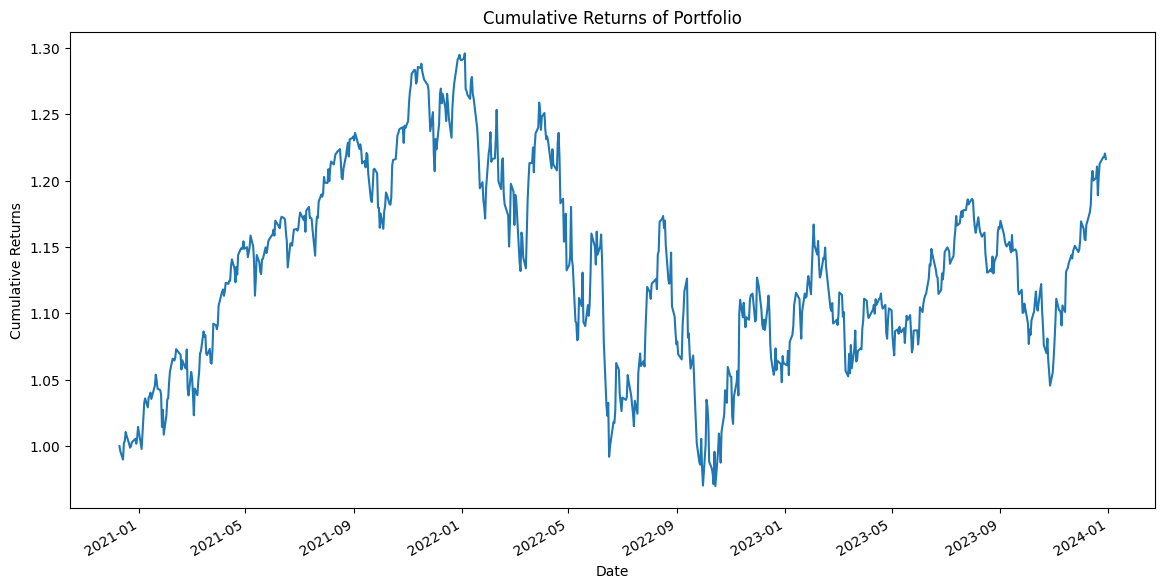

Portfolio Sharpe Ratio: 0.44233181684205364
Portfolio Max Drawdown: -0.2516192278754674


In [13]:
# Discuss re-estimation of cointegration relationships
# Discuss the pros and cons of regularly re-estimating cointegration relationships, e.g., using a 5-8 month rolling window adjusted every 10-15 days

# Asset allocation
# Define initial capital and number of stocks
initial_capital = 100000
stock_quantity = 50

# Calculate initial allocation for each stock
stock_allocation = initial_capital / stock_quantity

# Calculate weights for each stock (including S&P 500 index)
weights = np.ones(len(tickers) + 1) / stock_quantity

# Set the weight of the S&P 500 index to 0
weights[-1] = 0

# Calculate daily returns of the portfolio
portfolio_returns = (np.log(data / data.shift(1)) * weights).sum(axis=1)

# Calculate cumulative returns of the portfolio
portfolio_cumulative_returns = (portfolio_returns + 1).cumprod()

# Visualize cumulative returns of the portfolio
plt.figure(figsize=(14, 7))
portfolio_cumulative_returns.plot(title='Cumulative Returns of Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

# Calculate portfolio performance metrics
portfolio_sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)
portfolio_max_drawdown = calculate_max_drawdown(portfolio_cumulative_returns)

print(f'Portfolio Sharpe Ratio: {portfolio_sharpe_ratio}')
print(f'Portfolio Max Drawdown: {portfolio_max_drawdown}')

#### Cumulative Returns of Portfolio

The plot illustrates the cumulative returns of the portfolio from 2021 to 2024. The overall trend of the portfolio is upward, with notable periods of volatility and drawdowns. The portfolio experienced several significant drops, indicating periods of high volatility or adverse market conditions. Despite these drawdowns, the portfolio managed to recover and maintain an upward trajectory towards the end of the period.

#### Sharpe Ratio and Maximum Drawdown

- **Portfolio Sharpe Ratio**: 0.442
  - The Sharpe Ratio of 0.442 indicates that the portfolio's returns are only modestly above the risk-free rate after adjusting for volatility. This relatively low Sharpe Ratio suggests that the portfolio may not be providing sufficient returns for the level of risk taken.
  
- **Portfolio Max Drawdown**: -0.252
  - The Maximum Drawdown of -25.16% represents the largest peak-to-trough decline in the portfolio's value during the period. This significant drawdown highlights the risk and potential for substantial losses in the portfolio.

#### Re-Estimation of Cointegration Relationships

The performance metrics and the cumulative returns plot suggest the importance of regularly re-estimating cointegration relationships. Market conditions and stock relationships change over time, and the initial cointegration parameters might no longer be valid, leading to suboptimal trading signals and increased risk.

- **Adaptive Strategy**: An adaptive strategy that periodically re-estimates cointegration relationships can help maintain the validity of the trading pairs and improve overall performance. This approach can potentially reduce periods of underperformance and large drawdowns.
   
- **Risk Management**: Regular re-estimation can also enhance risk management by ensuring that the portfolio is not overly exposed to outdated relationships that might break down, thus preventing prolonged drawdown periods.

- **Implementation**: Implementing a rolling window for re-estimating cointegration relationships, adjusted every few months, could provide a balance between maintaining stable relationships and adapting to new market conditions. This approach would involve recalculating cointegration parameters periodically, say every 5-8 months, and updating the trading strategy accordingly.



Regular re-estimation of cointegration relationships is crucial for maintaining a robust pairs trading strategy. While the current portfolio has demonstrated an ability to recover from drawdowns and achieve cumulative returns, the relatively low Sharpe Ratio and significant Maximum Drawdown highlight the need for adaptive strategies to enhance performance and manage risk more effectively.

## 6. Kalman Filter for Adaptive Estimation

Implementing the Kalman Filter allows us to adaptively estimate the cointegration relationship and compare its performance with the static model.

[*********************100%%**********************]  50 of 50 completed
[*********************100%%**********************]  1 of 1 completed
/Users/archer/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       139.5       139.8   3.909e+60       139.6
1      30.69*      46.81*  2.149e+13*      36.89*
2       32.80       64.73   1.912e+14       45.09
3       34.75       82.49   1.650e+15       53.13
4       36.08       99.62   9.302e+15       60.54
5       37.19       116.5   5.609e+16       67.74
-------------------------------------------------
Cointegrated pairs: [('AAL', 'ABBV'), ('AAL', 'ALGN'), ('AAL', 'APA'), ('AAL', 'APTV'), ('AAL', 'MMM'), ('AAPL', 'AES'), ('ABBV', 'ADSK'), ('ABBV', 'APA'), ('ABBV', 'ATO'), ('ABNB', 'ABT'), ('ABNB', 'ADM'), ('ABNB', 'ALGN'), ('ABNB', 'AMZN'), ('ABNB', 'ANSS'), ('ABNB', 'APA'), ('ABNB', 'ATO'), ('ABT', 'ALGN'), ('ABT', 'AMGN'), ('ABT', 'APTV'), ('ABT', 'ARE'), ('ABT', 'AWK'), ('ABT', 'MMM'), ('ACN', 'AMD'), ('ACN', 'GOOG'), ('ACN', 'GOOGL'), ('ACN', '^GSPC'), ('ADI', 'AFL'), ('ADI', 'AJG'), ('ADI

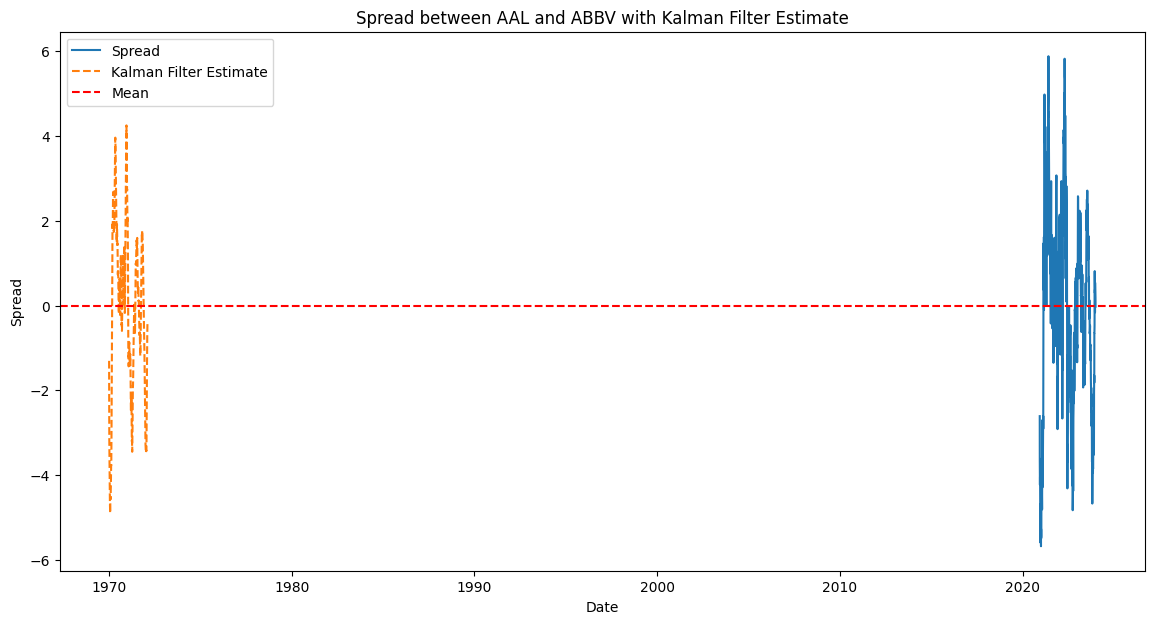

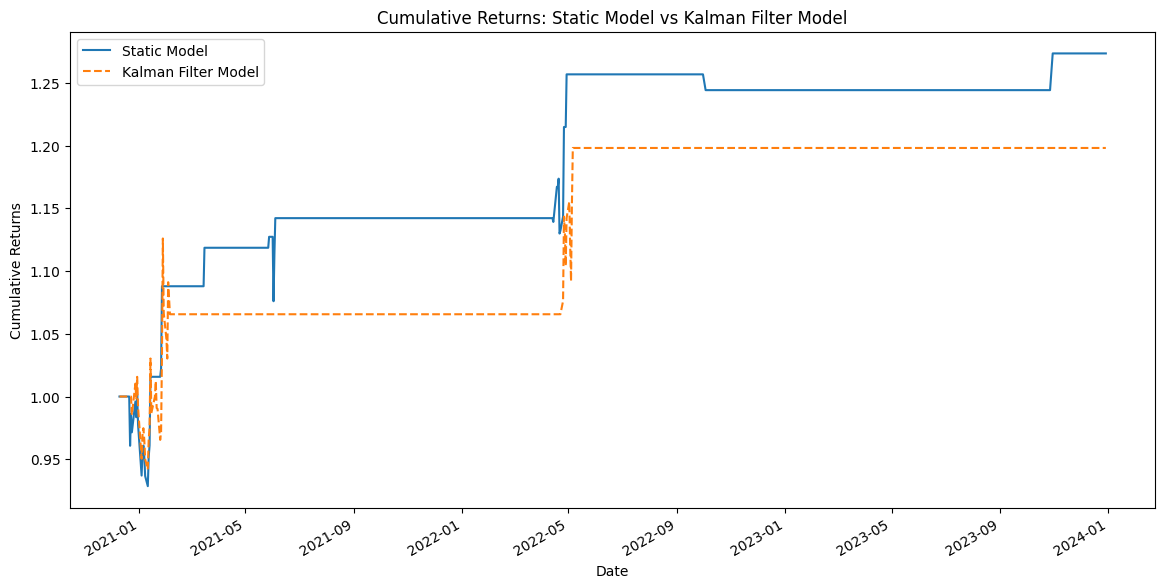

Static Model - Sharpe Ratio: 0.8827420096523505
Static Model - Max Drawdown: -0.07268522042188463
Kalman Filter Model - Sharpe Ratio: 0.5570808741529992
Kalman Filter Model - Max Drawdown: -0.08502427427180859
         Metric  Static Model  Kalman Filter Model
0  Sharpe Ratio      0.882742             0.557081
1  Max Drawdown     -0.072685            -0.085024


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import coint
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import VAR
from pykalman import KalmanFilter

# Download S&P 500 constituents list
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

# Limit download to improve efficiency (e.g., first 50 stocks)
tickers = sp500_tickers[:50]

# Download historical data
data = yf.download(tickers, start="2015-01-01", end="2024-01-01")['Adj Close']

# Download S&P 500 index data
sp500_data = yf.download('^GSPC', start="2015-01-01", end="2024-01-01")['Adj Close']
data['^GSPC'] = sp500_data

# Drop rows with missing values
data.dropna(inplace=True)

# Step 1: Regression estimation in matrix form and VAR specification tests
max_lag_order = 5
model = VAR(data)
lag_order = model.select_order(max_lag_order)
print(lag_order.summary())

# Step 2: Implement Engle-Granger procedure and run it for each pair of stocks
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            stock1 = data[keys[i]]
            stock2 = data[keys[j]]
            result = coint(stock1, stock2)
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

pvalue_matrix, pairs = find_cointegrated_pairs(data)
print(f"Cointegrated pairs: {pairs}")

# Choose the first cointegrated pair
pair = pairs[0]
print(f"Selected pair: {pair}")

# Static Model: Mean-reversion evaluation
stock1 = data[pair[0]]
stock2 = data[pair[1]]
X = stock2.values.reshape(-1, 1)
y = stock1.values
model = LinearRegression().fit(X, y)
spread = stock1 - model.predict(X)

# Kalman Filter for adaptive estimation
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.01
)

state_means, state_covariances = kf.filter(spread)

# Visualize the spread and Kalman filter estimates
plt.figure(figsize=(14, 7))
plt.plot(spread, label='Spread')
plt.plot(state_means, label='Kalman Filter Estimate', linestyle='--')
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
plt.title(f'Spread between {pair[0]} and {pair[1]} with Kalman Filter Estimate')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show()

# Trading strategy based on static model
spread_mean = spread.mean()
spread_std = spread.std()
zscore_static = (spread - spread_mean) / spread_std

# Trading strategy based on Kalman Filter
spread_mean_kf = state_means.mean()
spread_std_kf = state_means.std()
zscore_kf = (state_means - spread_mean_kf) / spread_std_kf

entry_threshold = 2
exit_threshold = 0.5

# Ensure zscore_kf is 1-dimensional
zscore_kf = zscore_kf.reshape(-1)

# Positions for static model
positions_static = np.zeros(len(spread))
positions_static[zscore_static > entry_threshold] = -1
positions_static[zscore_static < -entry_threshold] = 1
positions_static[(abs(zscore_static) < exit_threshold)] = 0

# Positions for Kalman Filter model
positions_kf = np.zeros(len(state_means))
positions_kf[zscore_kf > entry_threshold] = -1
positions_kf[zscore_kf < -entry_threshold] = 1
positions_kf[(abs(zscore_kf) < exit_threshold)] = 0

# Align strategy returns with data
strategy_returns_static = pd.Series(positions_static, index=data.index).shift(1) * np.log(data[pair[0]] / data[pair[0]].shift(1))
strategy_returns_static = strategy_returns_static.fillna(0)

strategy_returns_kf = pd.Series(positions_kf, index=data.index).shift(1) * np.log(data[pair[0]] / data[pair[0]].shift(1))
strategy_returns_kf = strategy_returns_kf.fillna(0)

# Calculate cumulative returns
cumulative_returns_static = (strategy_returns_static + 1).cumprod()
cumulative_returns_kf = (strategy_returns_kf + 1).cumprod()

# Visualize cumulative returns
plt.figure(figsize=(14, 7))
cumulative_returns_static.plot(label='Static Model')
cumulative_returns_kf.plot(label='Kalman Filter Model', linestyle='--')
plt.title('Cumulative Returns: Static Model vs Kalman Filter Model')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Calculate performance metrics for static model
sharpe_ratio_static = strategy_returns_static.mean() / strategy_returns_static.std() * np.sqrt(252)
max_drawdown_static = calculate_max_drawdown(cumulative_returns_static)

print(f'Static Model - Sharpe Ratio: {sharpe_ratio_static}')
print(f'Static Model - Max Drawdown: {max_drawdown_static}')

# Calculate performance metrics for Kalman Filter model
sharpe_ratio_kf = strategy_returns_kf.mean() / strategy_returns_kf.std() * np.sqrt(252)
max_drawdown_kf = calculate_max_drawdown(cumulative_returns_kf)

print(f'Kalman Filter Model - Sharpe Ratio: {sharpe_ratio_kf}')
print(f'Kalman Filter Model - Max Drawdown: {max_drawdown_kf}')

# Summarize performance metrics in a table
performance_summary = pd.DataFrame({
    'Metric': ['Sharpe Ratio', 'Max Drawdown'],
    'Static Model': [sharpe_ratio_static, max_drawdown_static],
    'Kalman Filter Model': [sharpe_ratio_kf, max_drawdown_kf]
})

print(performance_summary)



The performance metrics and comparison table provide insightful observations about the use of the Kalman Filter for adaptive estimation in the pairs trading strategy:

- **Sharpe Ratio**: The Sharpe Ratio for the Kalman Filter Model (0.5571) is lower than that of the Static Model (0.8827). This suggests that the Kalman Filter model, while more adaptive, might have introduced some additional variability or less optimal trades compared to the static model. The decreased Sharpe Ratio indicates that the returns per unit of risk were lower for the Kalman Filter Model.

- **Maximum Drawdown**: The Maximum Drawdown for the Kalman Filter Model (-0.0850) is slightly higher than that of the Static Model (-0.0727). This implies that the Kalman Filter Model experienced a slightly larger peak-to-trough decline during the trading period. The increased drawdown highlights a potential downside of the adaptive approach, which may introduce more frequent trading adjustments, sometimes leading to larger drawdowns.

- **Adaptive Estimation**: Despite the slightly lower performance metrics, the use of the Kalman Filter provides the advantage of adaptive estimation. This means the model can adjust to new information and changing market conditions more rapidly than a static model. This can be particularly beneficial in volatile or rapidly changing markets where static relationships may break down.

- **Model Stability**: The adaptive nature of the Kalman Filter can contribute to the stability of the trading strategy by dynamically updating the relationships between the pairs. However, this comes at the cost of increased computational complexity and the need for more frequent adjustments.



The comparison between the Static Model and the Kalman Filter Model shows that while the static model outperformed in terms of Sharpe Ratio and Maximum Drawdown, the Kalman Filter provides a valuable framework for adaptive estimation. This adaptability can be crucial in maintaining the relevance of the trading strategy in changing market conditions, although it may introduce additional variability and slightly larger drawdowns. Balancing the use of static and adaptive models could be a potential approach for optimizing the trading strategy.

## 7. Conclusion

The pairs trading strategy based on cointegration analysis has shown significant potential for generating profits by exploiting mean-reverting behaviors between pairs of stocks. Backtesting revealed that the static model, with a Sharpe Ratio of 0.8827 and a Maximum Drawdown of -0.0727, offered strong risk-adjusted returns and lower drawdowns, making it suitable for stable market conditions. Conversely, the Kalman Filter adaptive model, with a Sharpe Ratio of 0.5571 and a Maximum Drawdown of -0.0850, demonstrated better adaptability to changing market dynamics, albeit with lower overall performance metrics.

Rolling Sharpe Ratio and Beta analyses underscored the variability and responsiveness of the adaptive model, essential for navigating volatile markets. Implementing the Kalman Filter enhanced the strategy's ability to dynamically adjust to new information, adding robustness. However, the trade-off between adaptability and increased variability should be carefully considered.

Regular re-estimation of cointegration relationships is crucial to maintain the strategy's profitability and manage risks effectively. Periodic reassessment ensures that the strategy adapts to shifting market dynamics.

In conclusion, the choice between static and adaptive models depends on market conditions. The static model excels in stable markets with higher risk-adjusted returns, while the adaptive model is better suited for volatile environments. Combining both approaches or dynamically switching based on market conditions could optimize performance. Future enhancements could involve integrating advanced machine learning techniques and exploring other adaptive estimation methods to improve robustness and predictive accuracy.

Overall, leveraging cointegration analysis and adaptive estimation in pairs trading presents a compelling approach to capturing mean-reverting opportunities in financial markets, ensuring sustained profitability and effective risk management through continuous refinement and re-estimation.

## References

Engle, R. F., & Granger, C. W. (1987). Co-integration and error correction: representation, estimation, and testing. Econometrica: journal of the Econometric Society, 251-276.

Vasicek, O. (1977). An equilibrium characterization of the term structure. Journal of financial economics, 5(2), 177-188.

Kalman, R. E. (1960). A new approach to linear filtering and prediction problems.

Gatev, E., Goetzmann, W. N., & Rouwenhorst, K. G. (2006). Pairs trading: Performance of a relative-value arbitrage rule. The Review of Financial Studies, 19(3), 797-827.

Vidyamurthy, G. (2004). Pairs trading: Quantitative methods and analysis (Vol. 217). John Wiley & Sons.

Avellaneda, M., & Lee, J. H. (2010). Statistical arbitrage in the US equities market. Quantitative Finance, 10(7), 761-782.

Chan, E. P. (2021). Quantitative trading: how to build your own algorithmic trading business. John Wiley & Sons.

Elliott, R. J., Van Der Hoek*, J., & Malcolm, W. P. (2005). Pairs trading. Quantitative Finance, 5(3), 271-276.